<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/docs/docs/colab-notebook/orca/quickstart/pytorch_distributed_lenet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

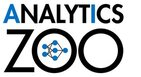
---

##### Copyright 2018 Analytics Zoo Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

 

[Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) is needed to prepare the Python environment for running this example. 

**Note**: The following code cell is specific for setting up conda environment on Colab; for general conda installation, please refer to the [install guide](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) for more details.

In [ ]:
import sys

# Set current python version
python_version = f"3.7.10"

In [ ]:
# Install Miniconda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python3.7/site-packages"))

os.environ['PYTHONHOME']="/usr/local"

You can install the latest pre-release version using `pip install --pre --upgrade analytics-zoo[ray]`.

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[ray]

In [ ]:
# Install python dependencies
!pip install torch==1.7.1 torchvision==0.8.2

## **Distributed PyTorch using Orca APIs**

In this guide we will describe how to scale out PyTorch programs using `torch_distributed` package on Orca in 4 simple steps.

In [ ]:
# import necesary libraries and modules
from __future__ import print_function
import os
import argparse

from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

### **Step 1: Init Orca Context**

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=1, memory="2g") # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
      cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
      driver_memory="10g", driver_cores=1) # run on Hadoop YARN cluster

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 2: Define the Model**
You may define your model, loss and optimizer in the same way as in any standard (single node) PyTorch program.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

criterion = nn.NLLLoss()

After defining your model, you need to define a *Model Creator Function* that returns an instance of your model, and a *Optimizer Creator Function* that returns a PyTorch optimizer.

In [ ]:
def model_creator(config):
    model = LeNet()
    return model

def optim_creator(model, config):
    return torch.optim.Adam(model.parameters(), lr=0.001)

### **Step 3: Define Train Dataset**

You can define the dataset using a *Data Creator Function* that has two parameters `config` and `batch_size` and returns a PyTorch `DataLoader`.

In [ ]:
import torch
from torchvision import datasets, transforms

torch.manual_seed(0)
batch_size = 320
test_batch_size = 320
dir = '/tmp/dataset'

def train_loader_creator(config, batch_size):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dir, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    return train_loader

def test_loader_creator(config, batch_size):
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dir, train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=False)
    return test_loader

### **Step 4: Fit with Orca Estimator**

First, Create an Estimator and set its backend to `torch_distributed`.

In [ ]:
from zoo.orca.learn.pytorch import Estimator
from zoo.orca.learn.metrics import Accuracy

est = Estimator.from_torch(model=model_creator, optimizer=optim_creator, loss=criterion, metrics=[Accuracy()],
                           backend="torch_distributed")

Next, fit and evaluate using the Estimator.

In [ ]:
from zoo.orca.learn.trigger import EveryEpoch 

est.fit(data=train_loader_creator, epochs=1, batch_size=batch_size)

Finally, evaluate using the Estimator.

In [ ]:
result = est.evaluate(data=test_loader_creator, batch_size=test_batch_size)
for r in result:
    print(r, ":", result[r])

The accuracy of this model has reached 98%.

In [ ]:
# stop orca context when program finishes
stop_orca_context()